
Trong notebook này, chúng ta sẽ thử quy trình lập trình RNN với Keras để phân loại các câu văn bản.

I.   **Trước tiên**, chúng ta sẽ nhập các thư viện hữu ích.

II.   **Sau đó**, chúng ta sẽ load dữ liệu và tạo ma trận word embedding bằng Glove.

III.  **Chúng ta sẽ thử một mô hình RNN đơn giản** rồi đánh giá chất lượng của nó.

IV. Cuối cùng, chúng ta sẽ sử dụng các kỹ thuật để gia tăng độ chính xác của mô hình.

**Task 1:** Thiết lập Fre GPU trong notebook này.

In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.4 MB/s eta 0:00:00


## Gắn Google Drive cục bộ
**Task 2:** Gắn Google vào Google Colab Driver.
 

In [2]:
## VIẾT CODE cho task 2 ở đây:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I. Nhập tất cả các thư viện hữu ích.

In [3]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import tensorflow.keras
import datetime
from tensorflow.keras import backend as K
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, load_model
import tensorflow_addons as tfa

from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plot
import seaborn as sn

**Task 3**: Copy tập dữ liệu từ Google Drive vào Colab

In [4]:
## VIẾT CODE cho task 3 ở đây:
!unzip drive/MyDrive/train.csv.zip

Archive:  drive/MyDrive/train.csv.zip
  inflating: train.csv               


# II. Load dữ liệu.

## Về tập dữ liệu.
Câu hỏi không hợp lệ là những câu hỏi nhằm đưa ra một tuyên bố thay vì tìm kiếm những câu trả lời hữu ích. Một số đặc điểm cho thấy câu hỏi không hợp lệ gồm:

* Có giọng điệu không trung lập.
* Có tính chê bai hoặc kích động.
* Không có căn cứ thực tế.
* Sử dụng nội dung khiêu dâm (loạn luân, thú tính, ấu dâm) để gây sốc, không phải để tìm kiếm câu trả lời xác thực.

Dữ liệu bao gồm câu hỏi đã đề ra và liệu nó có được xác định là không hợp lệ hay không (target = 1).

**Task 4**: Load tập dữ liệu.
* Load dữ liệu từ file CSV.
* Xóa tất cả các hàng có giá trị NA.
* Chia dữ liệu thành 3 tập: Tập huấn luyện, tập kiểm định và tập kiểm tra (0.9/0.05/0.05, random_seed = 9) với cùng một tỷ lệ số dữ liệu giữa mỗi lớp.
* In ra mô tả của tập dữ liệu này.
 



In [5]:
from sklearn.model_selection import train_test_split

In [6]:
def load_data(data_link):
    '''
    input: data link.
    output:
        train_set, validation_set và test_set(0.95/0.05/0.05) mà không có các giá trị NA.
    '''
    ## VIẾT CODE cho task 4 ở đây:
    data = pd.read_csv(data_link)
    data_no_na = data.dropna()
    train, test = train_test_split(data_no_na, train_size = 0.9, random_state = 9)
    test,validation = train_test_split(train, test_size = 0.5, random_state = 9)
    
    return train, validation, test

train_set, validation_set, test_set = load_data('train.csv')
print(train_set['target'].describe())
print(validation_set['target'].describe())
print(test_set['target'].describe())

count    1.175509e+06
mean     6.185150e-02
std      2.408858e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: target, dtype: float64
count    587755.000000
mean          0.061968
std           0.241098
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64
count    587754.000000
mean          0.061735
std           0.240674
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: target, dtype: float64


# Mã hóa dữ liệu văn bản.
Hãy khai báo một số tham số cơ bản trước:

In [7]:
embed_size = 50 # mỗi vectơ từ lớn bao nhiêu
max_features = 20000 # cần sử dụng bao nhiêu từ duy nhất (tức là số hàng trong vectơ embedding)
max_len = 50 # sử dụng số từ tối đa trong câu hỏi


**Task 5:** Mã hóa tập dữ liệu bằng Tokenizer và vectơ biểu diễn one-hot.
* Mã hóa văn bản (cột question_text) bằng cách chuyển từng question text thành danh sách chỉ mục từ bằng [Tokenizer](https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do) với **max_features** và tất cả các câu văn bản từ tập huấn luyện và tập kiểm định.
* Chuyển từng danh sách chỉ mục từ thành độ dài như nhau - **max_len** (có cắt tỉa hoặc đệm nếu cần) bằng cách sử dụng [pad_sequences](https://keras.io/preprocessing/sequence/).
* Mã hóa nhãn (cột nhãn) bằng cách sử dụng hàm [to_categorical](https://keras.io/utils/) trong Keras.

In [8]:
def encoding_textdata(train_set, validation_set, test_set, max_features, max_len):
    '''
    Input:
    - Train/validation/test dataset.
    - max_features, max_len.
    Output:
    - X train/validation/test, y train/validation/test.
    - Tokenizer.
    '''
    ## VIẾT CODE cho task 5 ở đây:
    X_tr = train_set['question_text'].values
    y_tr = train_set['target'].values
    X_va = validation_set['question_text'].values
    y_va = validation_set['target'].values
    X_te = test_set['question_text'].values
    y_te = test_set['target'].values


    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_tr))
    X_tr = tokenizer.texts_to_sequences(X_tr)
    X_tr = pad_sequences(X_tr, maxlen=max_len)
    y_tr = to_categorical(y_tr, num_classes=2)

    X_va = tokenizer.texts_to_sequences(X_va)
    X_va = pad_sequences(X_va, maxlen=max_len)
    y_va = to_categorical(y_va, num_classes=2)

    X_te = tokenizer.texts_to_sequences(X_te)
    X_te = pad_sequences(X_te, maxlen=max_len)
    y_te = to_categorical(y_te, num_classes=2)

    return (X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer

(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)

**Task 6**: Tạo ma trận word embedding.
* Đầu tiên, hãy viết một hàm để load [GloVe dictionary.](https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db)
* Sau đó, tạo ma trận word embedding bằng GloVe dictionary với các tham số sau:
    - Shape của ma trận word embedding: (Number of word, embed_size).
    - Embed size: 50. 
    - Number of words: Tối thiểu của (max_features, len(word_index)), trong khi word_index là dictionary của từ chứa trong tokenizer.
    - Nếu một từ xuất hiện trong GloVe dictionary, chúng ta nên lấy giá trị khởi tạo của nó như trong GloVe dictionary. Nếu không, hãy lấy một giá trị ngẫu nhiên bình thường với mean và std làm mean và std của giá trị GloVe dictionary.
    



In [9]:
!unzip drive/MyDrive/glove.6B.50d.txt.zip

Archive:  drive/MyDrive/glove.6B.50d.txt.zip
  inflating: glove.6B.50d.txt        


In [10]:
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    ## VIẾT CODE cho task 6 ở đây:
    embeddings_dict = {}
    with open(GloVe_link, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            token = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[token] = vector

    return embeddings_dict


GloVe_link = 'glove.6B.50d.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)

In [11]:
def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer từ tập huấn luyện và tập kiểm định, số lượng đặc trưng tối đa.
    output: Word embedding matrix.
    '''
    all_embs = np.stack(GloVe_dict.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = GloVe_dict.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix
    
embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


# III. Lập mô hình
Chúng ta cần hoàn thành một số bước: 

Xây dựng mô hình.

Biên dịch mô hình.

Huấn luyện/khớp dữ liệu với mô hình.

Đánh giá mô hình trên tập kiểm tra.

## Xây dựng mô hình
**Task 7:** Chúng ta có thể xây dựng một mô hình dễ dàng gồm các layer khác nhau như:
* Layer [Embedding](https://keras.io/layers/embeddings/) với max_features, embed_size và embedding_matrix.
* [Bidirectional LSTM layer](https://keras.io/examples/nlp/bidirectional_lstm_imdb/?fbclid=IwAR3fEd6aWyeIDEhZSspjtCRiP0c0Jnz5-XdnUHQYwX8Tp8k9Ni4I8Q5tP9o) với số lượng trạng thái ẩn = 50, dropout_rate = 0.1 và recurrent_dropout_rate = 0.1.
* GlobalMaxPool1D.
* Dense với số nút = 50, activation = 'relu'.
* Dropout với rate = 0.1.
* Final dense với số nút = số class, activation = 'sigmoid'.

In [12]:
def create_model(embedding_matrix, max_len, max_features, embed_size):
    '''
    input: max_len, max_features, embed_size
    output: model.
    '''
    ## VIẾT CODE cho task 7 ở đây:
    inp = Input(shape=(max_len,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    x = layers.Bidirectional(layers.LSTM(50, recurrent_dropout=0.1, dropout=0.1, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)

    return model

model = create_model(embedding_matrix, max_len, max_features, embed_size)

**Task 8:** Biên dịch mô hình và thiết lập callback. Sau đó in ra model summary.
* [Biên dịch](https://keras.io/models/model/#compile) mô hình với Adam Optimizer, lr = 1e-2, loss phù hợp cho bài toán phân loại nhị phân và ["F1-score"](https://github.com/tensorflow/addons/issues/825) là phép đo.
* In ra model summary.

In [13]:
def optimize(model):
    '''
    Input: 
        Mô hình.
    Return: 
        Mô hình đã biên dịch.
    '''
    ## VIẾT CODE cho task 8 ở đây:
    loss = tensorflow.keras.losses.BinaryCrossentropy()
    opt = optimizers.Adam(learning_rate = 1e-2)
    model.compile(optimizer = opt, loss=loss, metrics=[tfa.metrics.F1Score(num_classes = 2,average='macro',threshold=0.5)])

    return model

model = optimize(model)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 100)          40400     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0     

**Task 9**: Thiết lập callback.
* Tạo [tensorboard callback](https://www.tensorflow.org/tensorboard/tensorboard_in_notebooks) để lưu logs.
* Tạo [checkpoint callback](https://machinelearningmastery.com/check-point-deep-learning-models-keras/) để lưu checkpoint với độ chính xác tốt nhất sau mỗi epoch.
* Tạo [ReduceLROnPlateau](https://keras.io/callbacks/#reducelronplateau) callback với factor=0.3, patience=1 và "Validation F1-score" monitor.
* Tạo [early stopping callback](https://keras.io/callbacks/#earlystopping) với patience=7, mode = 'max' và "Validation F1-score" monitor.



In [14]:
def callback_model(checkpoint_name, logs_name):
    '''
    Input: 
        Checkpoint name, logs name tốt nhất.
    Return: 
        Callback list có chứa tensorboard callback và checkpoint callback.
    '''
    ## VIẾT CODE cho task 9 ở đây:

    logdir = os.path.join(logs_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)
    checkpoint = ModelCheckpoint(filepath=checkpoint_name, monitor='val_f1_score', verbose=1, save_best_only=True, mode='max')

    callbacks_list = [tensorflow.keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3, monitor='val_f1_score'),
        tensorflow.keras.callbacks.EarlyStopping(patience=7, mode='max', monitor='val_f1_score'),
        checkpoint,
        tensorboard_callback,
    ]
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 50, 100)          40400     
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 50)                5050      
                                                                 
 dropout (Dropout)           (None, 50)                0     

**Task 10:** Huấn luyện mô hình.

* Huấn luyện mô hình với 20 epoch với batch_size = 4096.
* Trả về mô hình có trọng số checkpoint tốt nhất.

*Gợi ý*: Trước tiên hãy khớp mô hình, sau đó reload mô hình (hàm load_model) với trọng số checkpoint tốt nhất.

In [16]:
def train_model(model, callbacks_list, X_tr, y_tr, X_va, y_va):
    '''
    Input: 
        Mô hình và callback list,
    Return: 
        Mô hình với trọng số checkpoint tốt nhất.
    '''
    ## VIẾT CODE cho task 10 ở đây:
    model.fit(X_tr, y_tr,
              epochs=20, 
              batch_size=4096,
              validation_data=(X_va, y_va), 
              callbacks=callbacks_list)
    model = load_model('weights.best.hdf5')
    return model

model = train_model(model, callbacks_list, X_tr, y_tr, X_va, y_va)

Epoch 1/20


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


287/287 [==============================] - ETA: 0s - loss: 0.1329 - f1_score: 0.6852
Epoch 1: val_f1_score improved from -inf to 0.81585, saving model to weights.best.hdf5
287/287 [==============================] - 186s 611ms/step - loss: 0.1329 - f1_score: 0.6852 - val_loss: 0.1055 - val_f1_score: 0.8158 - lr: 0.0100
Epoch 2/20
287/287 [==============================] - ETA: 0s - loss: 0.1056 - f1_score: 0.8085
Epoch 2: val_f1_score improved from 0.81585 to 0.83125, saving model to weights.best.hdf5
287/287 [==============================] - 157s 546ms/step - loss: 0.1056 - f1_score: 0.8085 - val_loss: 0.0957 - val_f1_score: 0.8312 - lr: 0.0100
Epoch 3/20
287/287 [==============================] - ETA: 0s - loss: 0.0951 - f1_score: 0.8298
Epoch 3: val_f1_score improved from 0.83125 to 0.85042, saving model to weights.best.hdf5
287/287 [==============================] - 146s 507ms/step - loss: 0.0951 - f1_score: 0.8298 - val_loss: 0.0893 - val_f1_score: 0.8504 - lr: 0.0030
Epoch 4/20
2

**Task 11:** Hiển thị tensorboard trong notebook.

In [17]:
## VIẾT CODE cho task 11 ở đây:

**Task 12:** Dự đoán trên tập kiểm tra.

* Hoàn thành hàm get_prediction_classes.
* In ra precision, recall và F1 score.

In [18]:
def get_prediction_classes(model, X, y):
    ## VIẾT CODE cho task 12 ở đây:
    '''
    Input: 
        Mô hình và tập dữ liệu dự đoán. 
    Return: 
        Prediction list và groundtrurth list với predicted classes. 
    '''
    groundtruths = model.predict(X)
    predictions = np.round(groundtruths)
    return predictions, y

    return predictions, groundtruths


test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)
print(precision_score(test_groundtruths, test_predictions, average='macro'))
print(recall_score(test_groundtruths, test_predictions, average='macro'))
print(f1_score(test_groundtruths, test_predictions, average='macro'))

18368/18368 [==============================] - 559s 30ms/step
0.8534243527931547
0.8554225701734304
0.8544195416024838


**Task 13:** Thực hiện kết quả dự đoán trên tập kiểm tra bằng cách sử dụng ma trận nhầm lẫn. Hãy nhớ hiển thị tên lớp trong ma trận nhầm lẫn.

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

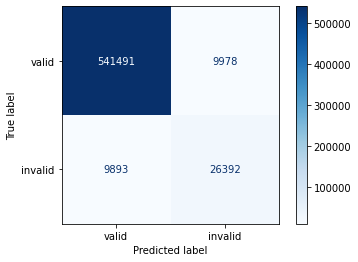

In [20]:
def plot_confusion_matrix(predictions, groundtruth, class_names):
    ## VIẾT CODE cho task 13 ở đây:
    con_mat = confusion_matrix(groundtruth.argmax(axis=1) , predictions.argmax(axis=1))   
    disp = ConfusionMatrixDisplay(confusion_matrix=con_mat, display_labels=class_names)

    disp.plot(cmap=plot.cm.Blues)
    plot.show()

class_names = ['valid', 'invalid']
plot_confusion_matrix(test_predictions, test_groundtruths, class_names)

**Task 14**: Tinh chỉnh mô hình - tinh chỉnh mô hình bằng cách sử dụng một số phương pháp sau:
* Tăng tối đa epoch, thay đổi batch size.
* Thay thế LSTM bằng các nút GRU và kiểm tra xem nó có thay đổi gì không.
* Thêm một layer LSTM/GRU khác hoặc thay thế nó bằng mô-đun Attention/Transformers, xem có cải thiện gì không.
* Thử với Dense layer (add/# units/...).
* Tìm các quy tắc tiền xử lý mà bạn có thể thêm để cải thiện chất lượng dữ liệu. 
* Find another GloVe dictionary. Tìm một GloVe dictionary khác.
Yêu cầu: F1 score phải tăng thêm 2-3%.

In [21]:
## VIẾT CODE cho task 14 ở đây:
train_set, validation_set, test_set = load_data('train.csv')

embed_size = 100
max_features = 50000
maxlen = 200

(X_tr, y_tr), (X_va, y_va), (X_te, y_te), tokenizer = encoding_textdata(train_set, validation_set, test_set, max_features, max_len)

In [22]:
!unzip drive/MyDrive/glove.6B.100d.txt.zip

Archive:  drive/MyDrive/glove.6B.100d.txt.zip
  inflating: glove.6B.100d.txt       


In [23]:
def get_GloVe_dict(GloVe_link):
    '''
    input: GloVe link.
    output: GloVe dictionary.
    '''
    ## VIẾT CODE cho task 6 ở đây:
    embeddings_dict = {}
    with open(GloVe_link, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            token = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[token] = vector

    return embeddings_dict


GloVe_link = 'glove.6B.100d.txt'
GloVe_dict = get_GloVe_dict(GloVe_link)

In [24]:
def create_embedding_matrix(GloVe_dict, tokenizer, max_features):
    '''
    input: GloVe dictionaray, tokenizer từ tập huấn luyện và tập kiểm định, số lượng đặc trưng tối đa.
    output: Word embedding matrix.
    '''
    all_embs = np.stack(GloVe_dict.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = GloVe_dict.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix
    
embedding_matrix = create_embedding_matrix(GloVe_dict, tokenizer, max_features)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
embedding_matrix.shape

(50000, 100)

In [26]:
def create_model_v2(embedding_matrix,max_len, max_features, embed_size):
    inp = Input(shape=(max_len,))
    x = Embedding(max_features, embed_size)(inp)
    x = layers.Bidirectional(layers.GRU(64, weights = [embedding_matrix], return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(128,activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(2, activation = 'sigmoid')(x)
    model = Model(inputs = inp, outputs = x)

    return model

model_v2 = create_model_v2(embedding_matrix, max_len, max_features, embed_size)

In [27]:
model_2 = optimize(model_v2)
print(model_v2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           5000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 128)          63744     
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0   

In [28]:
checkpoint_name = 'v2_weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name,logs_name)

In [29]:
def train_model(model, callbacks_list, X_tr, y_tr, X_va, y_va):

    model.fit(X_tr, y_tr,
            epochs = 20,
            batch_size = 256,
            validation_data = (X_va, y_va),
            callbacks = callbacks_list)
    model = load_model('v2_weights.best.hdf5')
    return model
model_v2 = train_model(model_v2, callbacks_list, X_tr,y_tr,X_va,y_va)

Epoch 1/20
4592/4592 [==============================] - ETA: 0s - loss: 0.1275 - f1_score: 0.7363
Epoch 1: val_f1_score improved from -inf to 0.73091, saving model to v2_weights.best.hdf5
4592/4592 [==============================] - 108s 22ms/step - loss: 0.1275 - f1_score: 0.7363 - val_loss: 0.1159 - val_f1_score: 0.7309 - lr: 0.0100
Epoch 2/20
4592/4592 [==============================] - ETA: 0s - loss: 0.1181 - f1_score: 0.7624
Epoch 2: val_f1_score improved from 0.73091 to 0.78344, saving model to v2_weights.best.hdf5
4592/4592 [==============================] - 66s 14ms/step - loss: 0.1181 - f1_score: 0.7624 - val_loss: 0.1105 - val_f1_score: 0.7834 - lr: 0.0100
Epoch 3/20
4592/4592 [==============================] - ETA: 0s - loss: 0.1094 - f1_score: 0.7852
Epoch 3: val_f1_score improved from 0.78344 to 0.78909, saving model to v2_weights.best.hdf5
4592/4592 [==============================] - 62s 14ms/step - loss: 0.1094 - f1_score: 0.7852 - val_loss: 0.1041 - val_f1_score: 0.789

In [30]:
test_predictions, test_groundtruths = get_prediction_classes(model,  X_te, y_te)
print(precision_score(test_groundtruths, test_predictions, average='macro'))
print(recall_score(test_groundtruths, test_predictions, average='macro'))
print(f1_score(test_groundtruths, test_predictions, average='macro'))

18368/18368 [==============================] - 593s 32ms/step
0.8497658654273993
0.8610738582981136
0.8553103650761693


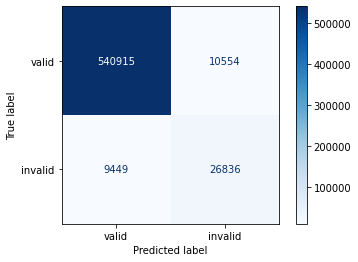

In [31]:
class_name = ['valid','invalid']
plot_confusion_matrix(test_predictions,test_groundtruths,class_name)